## Import the dependencies

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

## Load the Dataset

In [3]:
df = pd.read_csv('./../../data/sierraleone-bumbuna.csv')
df.head()

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-10-30 00:01,-0.7,-0.1,-0.8,0.0,0.0,21.9,99.1,0.0,0.0,0.0,0.0,0.0,1002,0,0.0,22.3,22.6,NaN
1,2021-10-30 00:02,-0.7,-0.1,-0.8,0.0,0.0,21.9,99.2,0.0,0.0,0.0,0.0,0.0,1002,0,0.0,22.3,22.6,NaN
2,2021-10-30 00:03,-0.7,-0.1,-0.8,0.0,0.0,21.9,99.2,0.0,0.0,0.0,0.0,0.0,1002,0,0.0,22.3,22.6,NaN
3,2021-10-30 00:04,-0.7,0.0,-0.8,0.0,0.0,21.9,99.3,0.0,0.0,0.0,0.0,0.0,1002,0,0.1,22.3,22.6,NaN
4,2021-10-30 00:05,-0.7,-0.1,-0.8,0.0,0.0,21.9,99.3,0.0,0.0,0.0,0.0,0.0,1002,0,0.0,22.3,22.6,NaN


# 1. Summary Statistics & Missing-Value Report

In [4]:
# Overview of numeric columns
print("The description of the numeric columns:")
print(df.describe())

# Check for missing values
print("----------------------------------")
print("Check for missing values:")
print(df.isna().sum())

# List any columns with >5% nulls
null_percentage = df.isna().mean() * 100  # in percentage
columns_with_high_nulls = null_percentage[null_percentage > 5]
print(columns_with_high_nulls)


The description of the numeric columns:
                 GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      201.957515     116.376337     113.720571     206.643095   
std       298.495150     218.652659     158.946032     300.896893   
min       -19.500000      -7.800000     -17.900000       0.000000   
25%        -2.800000      -0.300000      -3.800000       0.000000   
50%         0.300000      -0.100000      -0.100000       3.600000   
75%       362.400000     107.000000     224.700000     359.500000   
max      1499.000000     946.000000     892.000000    1507.000000   

                ModB           Tamb             RH             WS  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      198.114691      26.319394      79.448857       1.146113   
std       288.889073       4.398605      20.520775       1.239248   
min         0.000000      12.300000       9.900000       0.000


# 2. Outlier Detection

In [5]:
def plot_correlation_matrix(df):
    """
    Plot the correlation matrix of the dataset.
    :param df: The dataset
    :return: None
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True)
    plt.title("Correlation Matrix")
    plt.show()

In [6]:
# Check missing values per column and flag those with >5% nulls

nulls = df.isna().mean() * 100
print("Columns with >5% missing values:")
print(nulls[nulls > 5])


Columns with >5% missing values:
Comments    100.0
dtype: float64


In [7]:
# Incorrect Entries: Negative Values in Irradiance Columns
irradiance_cols = ['GHI', 'DNI', 'DHI']
for col in irradiance_cols:
    print(f"{col} has {df[df[col] < 0].shape[0]} negative values.")

# filter these values or replace them with NaN for downstream cleaning
for col in irradiance_cols:
    df.loc[df[col] < 0, col] = np.nan



GHI has 261135 negative values.
DNI has 266352 negative values.
DHI has 263128 negative values.


In [8]:
# Outlier Detection for Sensor and Wind Data Using a simple IQR-based approach for outliers
def detect_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return series[(series < lower) | (series > upper)]

columns_to_check = ['ModA', 'ModB', 'WS', 'WSgust']

for col in columns_to_check:
    outliers = detect_outliers(df[col])
    print(f"{col}: {len(outliers)} outliers")


ModA: 21017 outliers
ModB: 20613 outliers
WS: 3169 outliers
WSgust: 3665 outliers


## 2.1 Compute Z-scores

In [9]:
import pandas as pd
import numpy as np
from scipy.stats import zscore

# List of columns to compute Z-scores
cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# Drop rows with NaNs in selected columns to avoid errors in zscore computation
z_df = df[cols].dropna()

# Compute Z-scores for each column
z_scores = z_df.apply(zscore)

# Flag rows with any Z-score > 3 or < -3
outlier_mask = (np.abs(z_scores) > 3).any(axis=1)

# Get the indices or rows with outliers
outlier_rows = z_scores[outlier_mask]
print(f"Number of outlier rows: {outlier_rows.shape[0]}")

# If you want to see full rows from the original df:
original_outlier_rows = df.loc[outlier_rows.index]



Number of outlier rows: 1760


## 2.2 Imputation

In [10]:
# Ensure key_cols is defined
if 'key_cols' not in locals():
    key_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# Impute key sensor columns
for col in key_cols:
    df[col].fillna(df[col].median(), inplace=True)

# Drop rows where other essential columns (e.g., Timestamp) are missing
df.dropna(subset=['Timestamp'], inplace=True)


/tmp/ipykernel_28377/3744149603.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipykernel_28377/3744149603.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

## 2.3 Export cleaned DataFrame

In [29]:
import os

# Set the country name and path
country = "sierraleone".lower()
output_dir = "data"
output_path = f"{output_dir}/{country}_clean.csv"

# Create the data directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Export the cleaned DataFrame
df.to_csv(output_path, index=False)
print(f"Cleaned data exported to: {output_path}")


Cleaned data exported to: data/sierraleone_clean.csv


# 3. Time Series Analysis

### 3.1 Line Chart

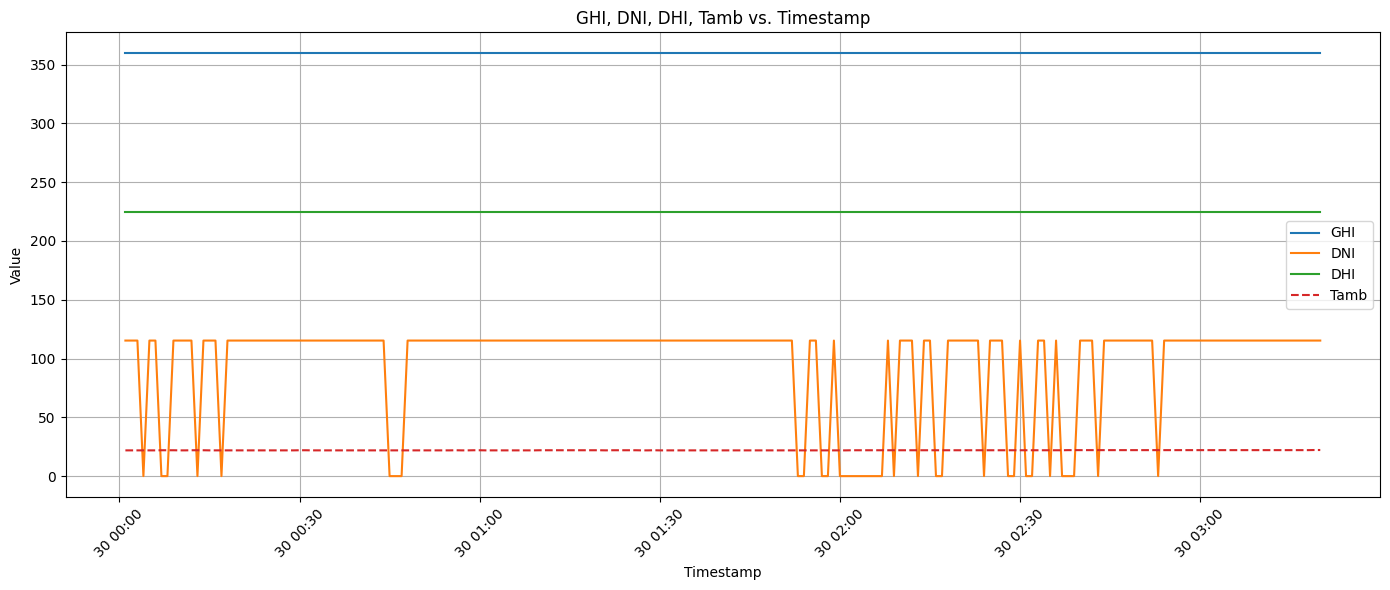

In [30]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp is datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Subset data for clarity (e.g. first 200 records)
subset = df[['Timestamp', 'GHI', 'DNI', 'DHI', 'Tamb']].head(200)

plt.figure(figsize=(14, 6))
plt.plot(subset['Timestamp'], subset['GHI'], label='GHI')
plt.plot(subset['Timestamp'], subset['DNI'], label='DNI')
plt.plot(subset['Timestamp'], subset['DHI'], label='DHI')
plt.plot(subset['Timestamp'], subset['Tamb'], label='Tamb', linestyle='--')

plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('GHI, DNI, DHI, Tamb vs. Timestamp')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

### 3.2 Bar Chart

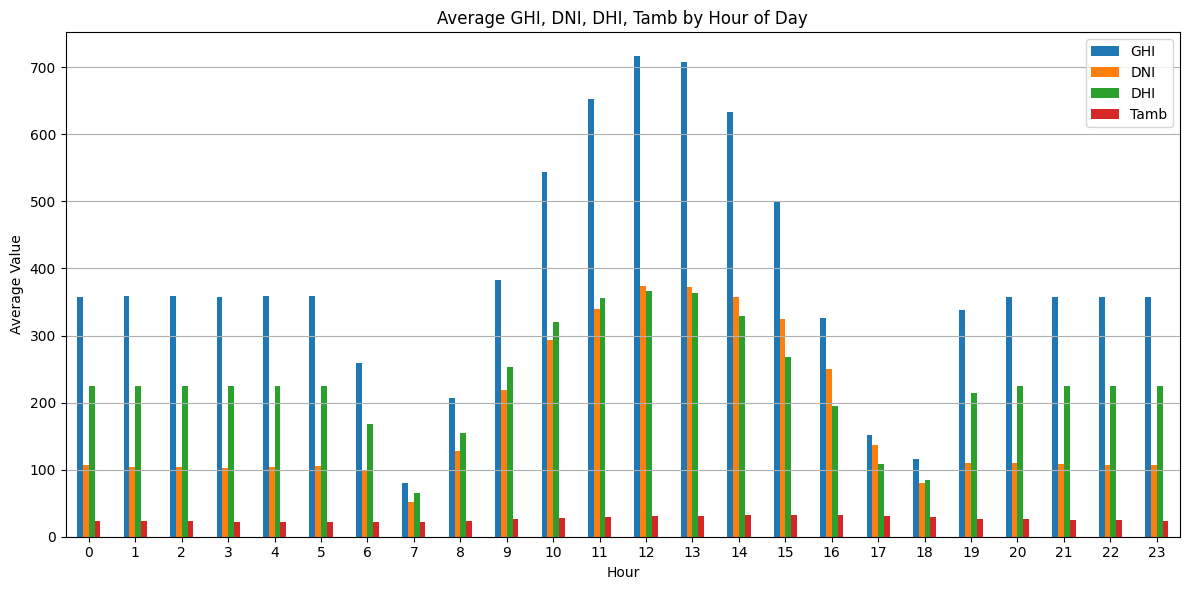

In [31]:
df['Hour'] = df['Timestamp'].dt.hour
hourly_avg = df.groupby('Hour')[['GHI', 'DNI', 'DHI', 'Tamb']].mean()

hourly_avg.plot(kind='bar', figsize=(12, 6))
plt.title('Average GHI, DNI, DHI, Tamb by Hour of Day')
plt.ylabel('Average Value')
plt.xlabel('Hour')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


Step 1: Parse Timestamps & Create Time Features

In [32]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Month'] = df['Timestamp'].dt.month
df['Hour'] = df['Timestamp'].dt.hour
df['Date'] = df['Timestamp'].dt.date


Step 2: Analyze Patterns by Month

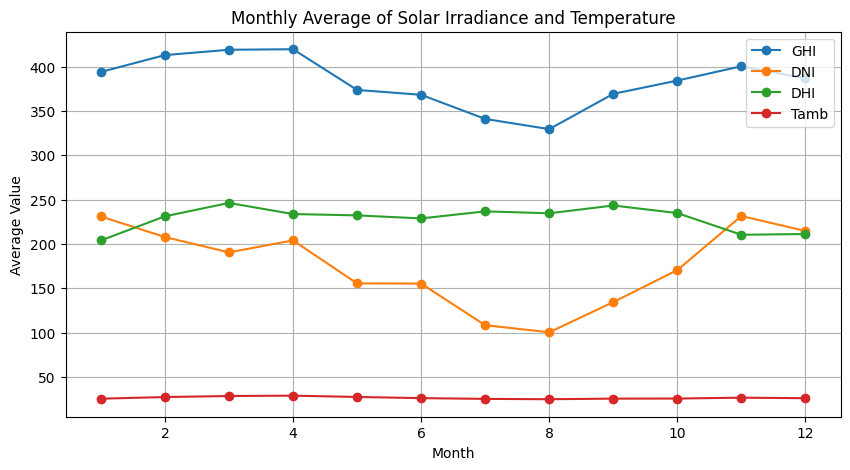

In [33]:
import matplotlib.pyplot as plt

monthly_avg = df.groupby('Month')[['GHI', 'DNI', 'DHI', 'Tamb']].mean()

monthly_avg.plot(kind='line', marker='o', figsize=(10, 5))
plt.title("Monthly Average of Solar Irradiance and Temperature")
plt.ylabel("Average Value")
plt.xlabel("Month")
plt.grid(True)
plt.show()


Step 3: Observe Trends Throughout the Day

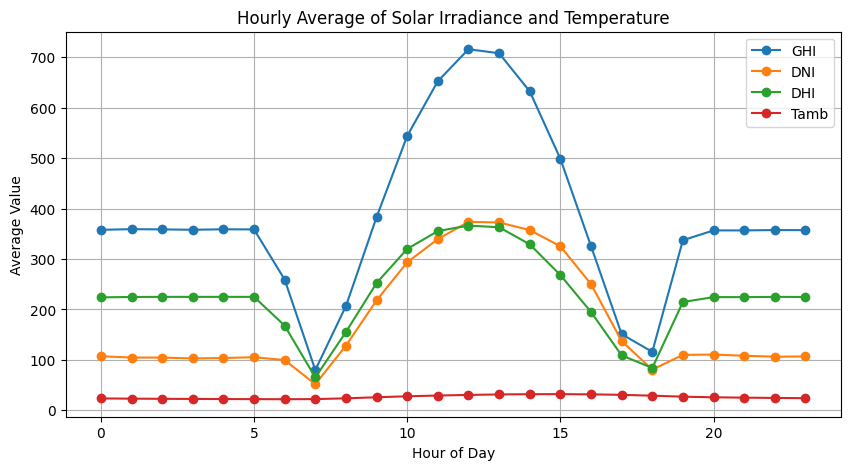

In [34]:
hourly_avg = df.groupby('Hour')[['GHI', 'DNI', 'DHI', 'Tamb']].mean()

hourly_avg.plot(kind='line', marker='o', figsize=(10, 5))
plt.title("Hourly Average of Solar Irradiance and Temperature")
plt.ylabel("Average Value")
plt.xlabel("Hour of Day")
plt.grid(True)
plt.show()


Step 4: Detect Anomalies (e.g. sudden peaks or drops)

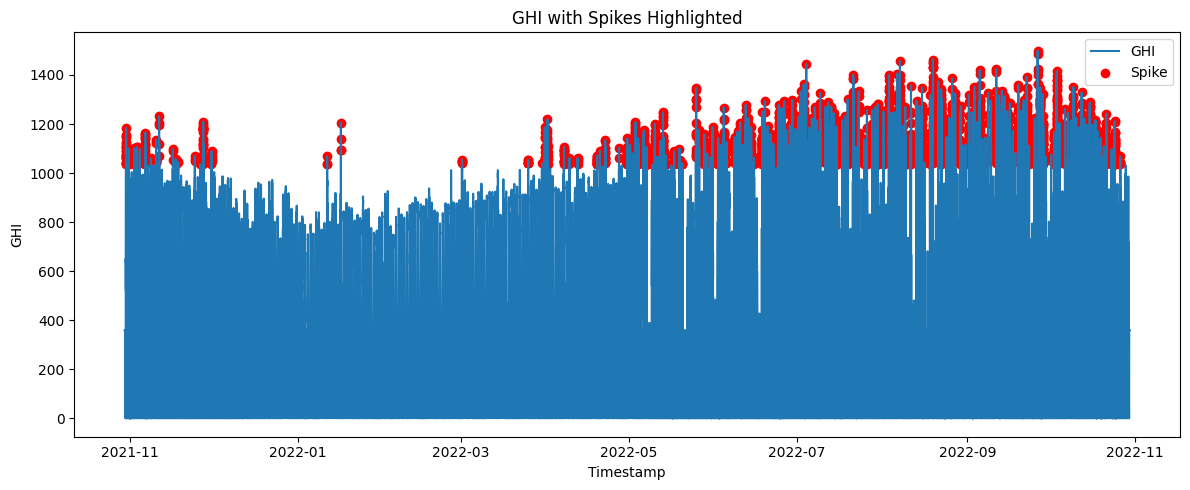

In [35]:
# Simple spike detection for GHI
ghi_threshold = df['GHI'].mean() + 3 * df['GHI'].std()
ghi_spikes = df[df['GHI'] > ghi_threshold]

# Plot spikes
plt.figure(figsize=(12, 5))
plt.plot(df['Timestamp'], df['GHI'], label='GHI')
plt.scatter(ghi_spikes['Timestamp'], ghi_spikes['GHI'], color='red', label='Spike')
plt.title('GHI with Spikes Highlighted')
plt.xlabel('Timestamp')
plt.ylabel('GHI')
plt.legend()
plt.tight_layout()
plt.show()


# 4. Cleaning Impact

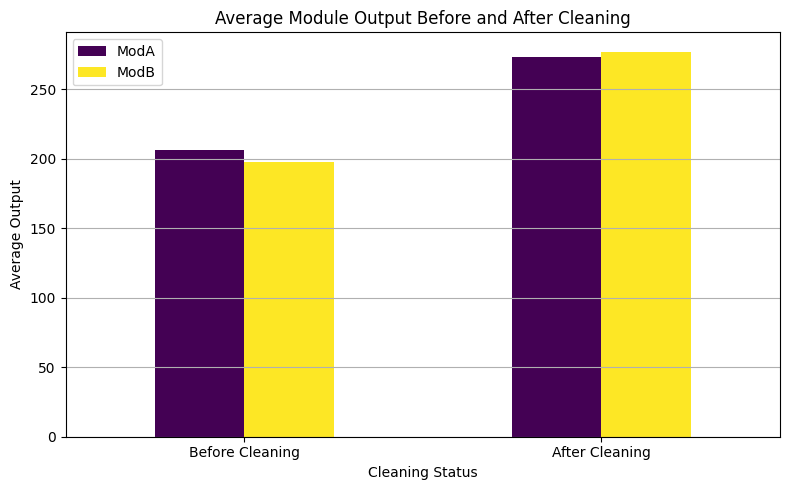

In [36]:
import matplotlib.pyplot as plt

# Group by Cleaning flag and calculate mean of ModA and ModB
mod_avg = df.groupby('Cleaning')[['ModA', 'ModB']].mean().rename(index={0: 'Before Cleaning', 1: 'After Cleaning'})

# Plot
mod_avg.plot(kind='bar', figsize=(8, 5), rot=0, colormap='viridis')
plt.title('Average Module Output Before and After Cleaning')
plt.ylabel('Average Output')
plt.xlabel('Cleaning Status')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


# 5. Correlation & Relationship Analysis

### 5.1 heatmap of correlations

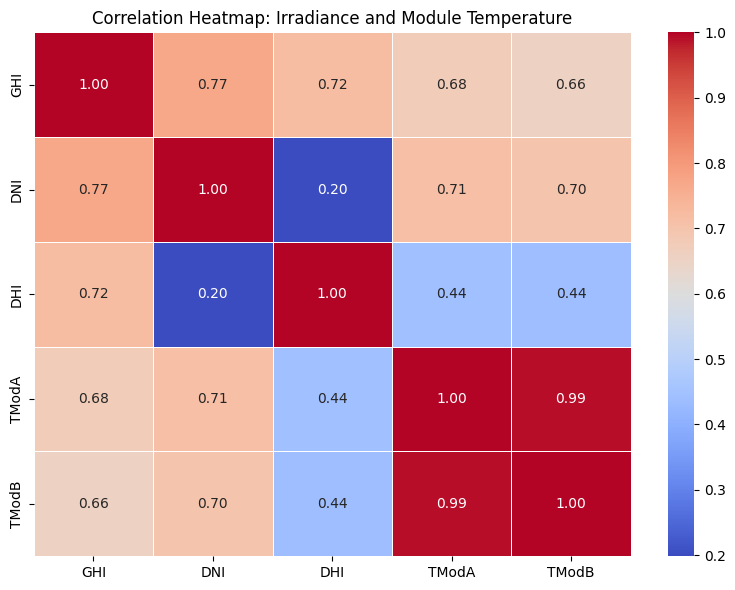

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant columns
cols = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB']
corr_matrix = df[cols].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap: Irradiance and Module Temperature")
plt.tight_layout()
plt.show()


### 5.2.1. Wind Speed (WS), Gust (WSgust), Direction (WD) vs. GHI

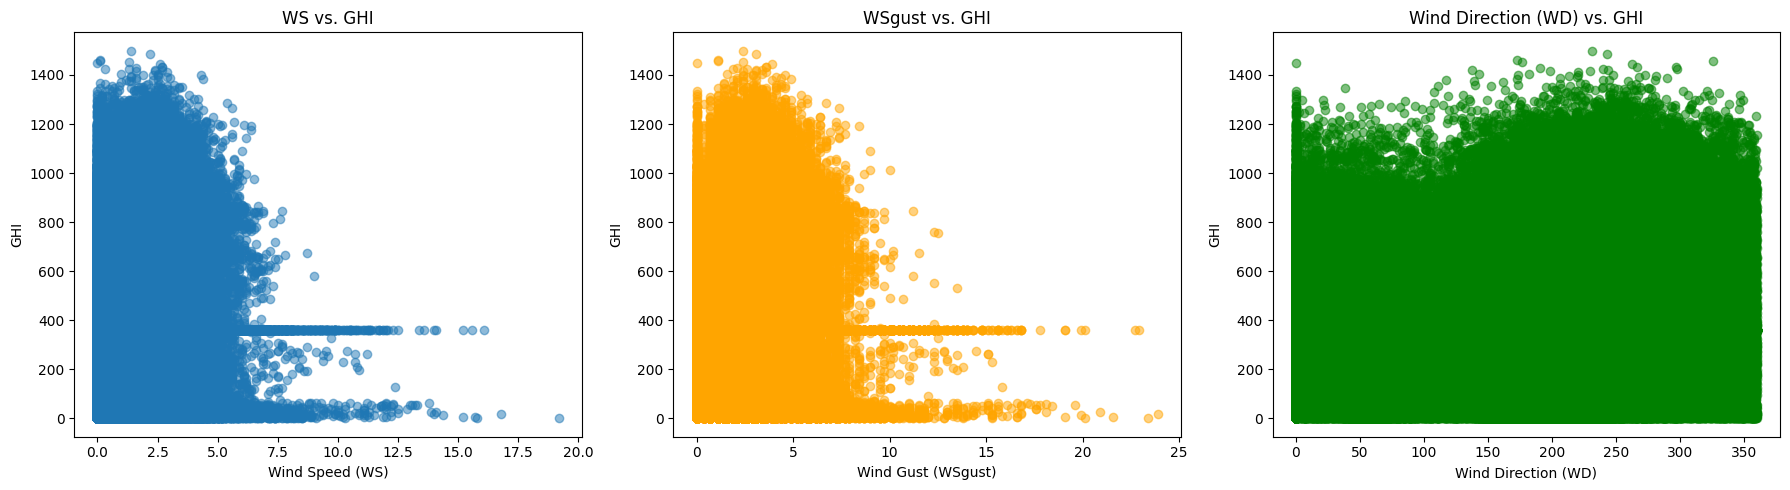

In [38]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].scatter(df['WS'], df['GHI'], alpha=0.5)
axs[0].set_title('WS vs. GHI')
axs[0].set_xlabel('Wind Speed (WS)')
axs[0].set_ylabel('GHI')

axs[1].scatter(df['WSgust'], df['GHI'], alpha=0.5, color='orange')
axs[1].set_title('WSgust vs. GHI')
axs[1].set_xlabel('Wind Gust (WSgust)')
axs[1].set_ylabel('GHI')

axs[2].scatter(df['WD'], df['GHI'], alpha=0.5, color='green')
axs[2].set_title('Wind Direction (WD) vs. GHI')
axs[2].set_xlabel('Wind Direction (WD)')
axs[2].set_ylabel('GHI')

plt.tight_layout()
plt.show()


 ### 5.2 Relative Humidity (RH) vs. Tamb and GHI

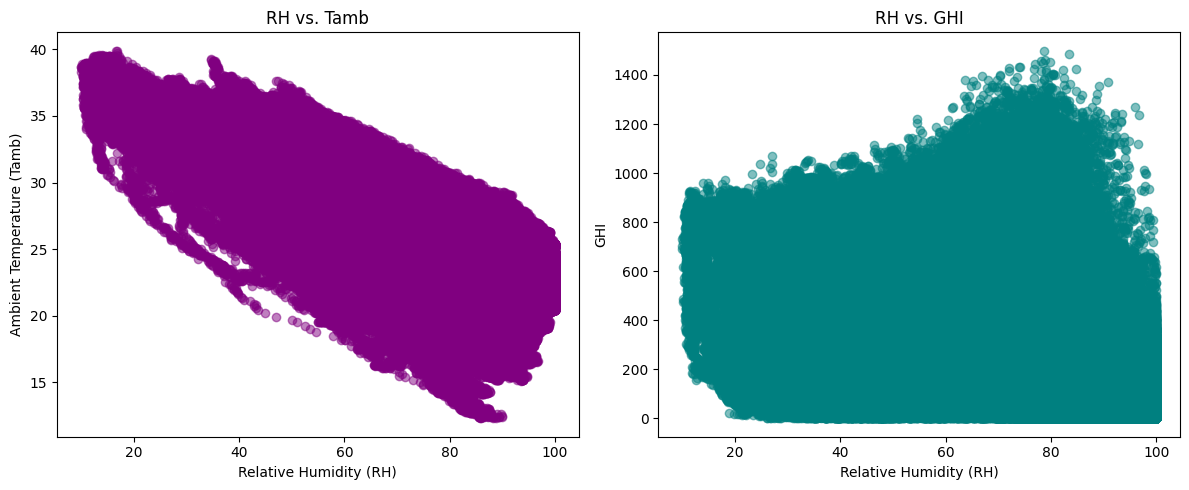

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(df['RH'], df['Tamb'], alpha=0.5, color='purple')
axs[0].set_title('RH vs. Tamb')
axs[0].set_xlabel('Relative Humidity (RH)')
axs[0].set_ylabel('Ambient Temperature (Tamb)')

axs[1].scatter(df['RH'], df['GHI'], alpha=0.5, color='teal')
axs[1].set_title('RH vs. GHI')
axs[1].set_xlabel('Relative Humidity (RH)')
axs[1].set_ylabel('GHI')

plt.tight_layout()
plt.show()


# 6. Wind & Distribution Analysis

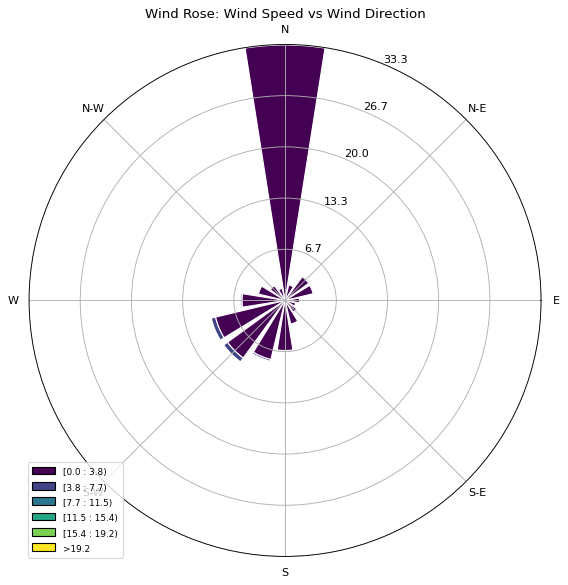

In [40]:
from windrose import WindroseAxes
import matplotlib.pyplot as plt

# Drop NaNs for wind columns
wind_data = df[['WD', 'WS']].dropna()

# Create wind rose
ax = WindroseAxes.from_ax()
ax.bar(wind_data['WD'], wind_data['WS'], normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
plt.title('Wind Rose: Wind Speed vs Wind Direction')
plt.show()


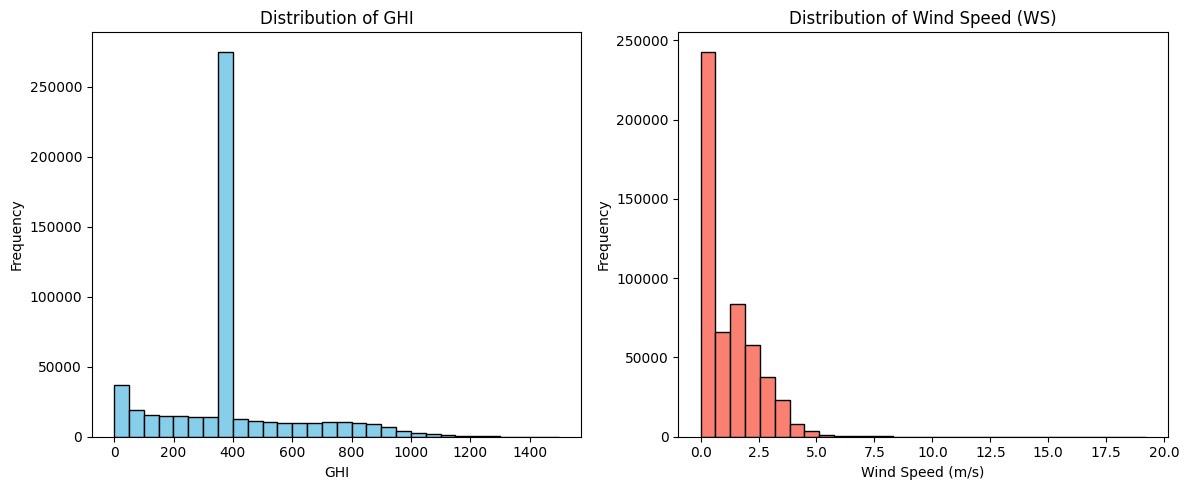

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].hist(df['GHI'].dropna(), bins=30, color='skyblue', edgecolor='black')
axs[0].set_title('Distribution of GHI')
axs[0].set_xlabel('GHI')
axs[0].set_ylabel('Frequency')

axs[1].hist(df['WS'].dropna(), bins=30, color='salmon', edgecolor='black')
axs[1].set_title('Distribution of Wind Speed (WS)')
axs[1].set_xlabel('Wind Speed (m/s)')
axs[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


# 7. Temperature Analysis

In [42]:
correlation = df[['RH', 'Tamb', 'GHI', 'DNI', 'DHI']].corr()
print(correlation['RH'])


RH      1.000000
Tamb   -0.791937
GHI    -0.390534
DNI    -0.496298
DHI    -0.179840
Name: RH, dtype: float64


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lmplot(data=df, x='RH', y='Tamb', scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title('RH vs. Ambient Temperature (Tamb)')
plt.grid(True)
plt.show()


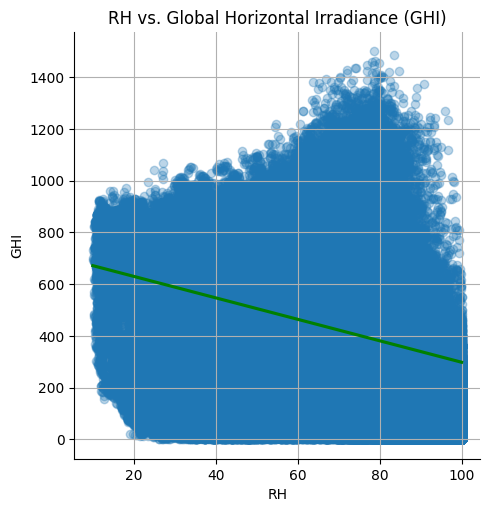

In [ ]:
sns.lmplot(data=df, x='RH', y='GHI', scatter_kws={'alpha':0.3}, line_kws={'color':'green'})
plt.title('RH vs. Global Horizontal Irradiance (GHI)')
plt.grid(True)
plt.show()


# 8. Bubble Chart

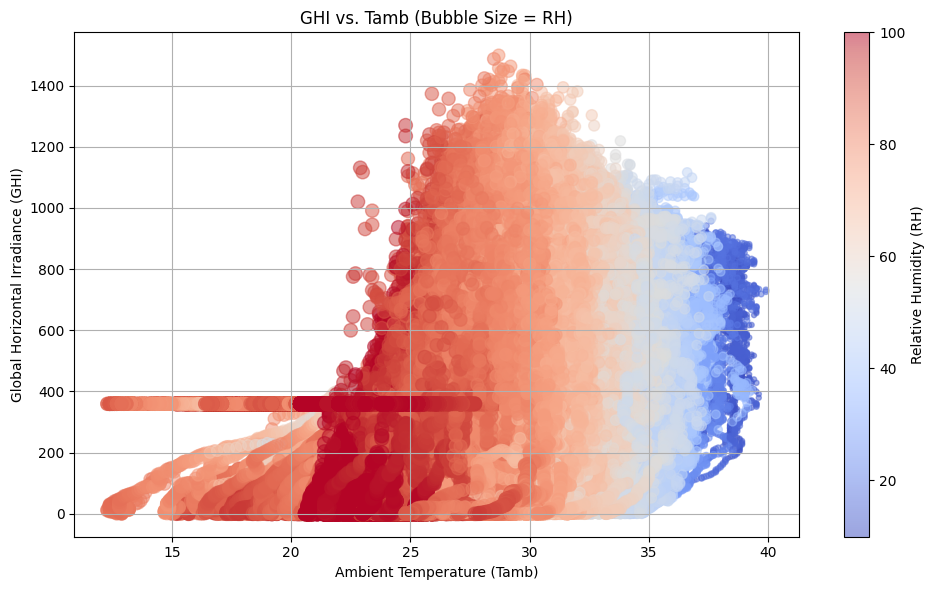

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(df['Tamb'], df['GHI'], s=df['RH'], alpha=0.5, c=df['RH'], cmap='coolwarm')
plt.title('GHI vs. Tamb (Bubble Size = RH)')
plt.xlabel('Ambient Temperature (Tamb)')
plt.ylabel('Global Horizontal Irradiance (GHI)')
plt.colorbar(label='Relative Humidity (RH)')
plt.grid(True)
plt.tight_layout()
plt.show()
